In [1]:
#in this script we are re-performing QC on the ATO_T6 dataset
#in this script we are extracting and processing the read files for the w5 ishiguro ATO data, and performing QC
import scanpy as sc
import anndata as ad
import pandas as pd
import os

In [2]:
adata = ad.read_h5ad("/g/data/yr31/hb1618/iPSC_project/datasets/g2g_ipsc/ATO.h5ad")

In [3]:
#examining dataset
print(adata)

AnnData object with n_obs × n_vars = 31483 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'souporcell_doublet_prediction', 'souporcell_doublet_logprob', 'batch', 'sample', 'time_id', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'new_annotation'
    var: 'mt'


In [4]:
#subsetting to the T06 timepoint (week 7)
adata = adata[adata.obs.time_id == "T06 GEX"].copy()

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 6573 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'souporcell_doublet_prediction', 'souporcell_doublet_logprob', 'batch', 'sample', 'time_id', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'new_annotation'
    var: 'mt'


In [6]:
#now that we have loaded up the countdata and metadata, we can proceed with QC
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))

In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

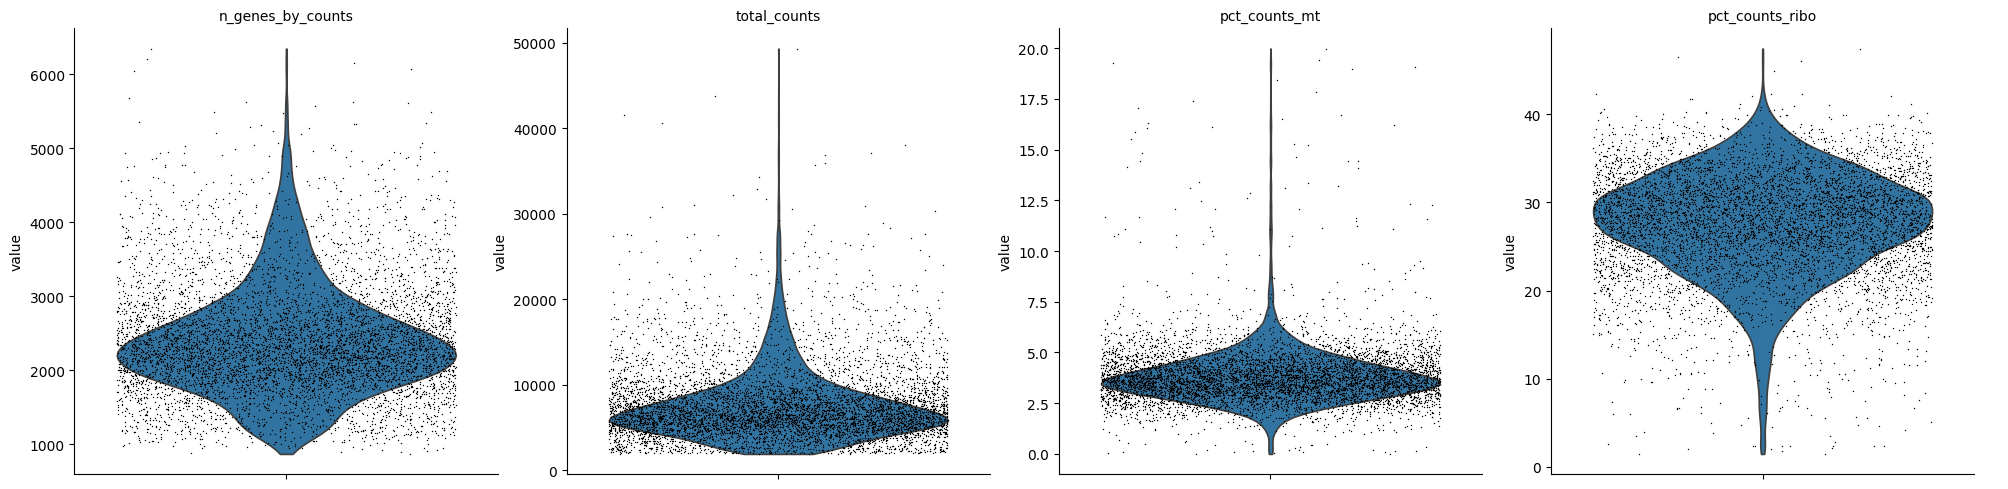

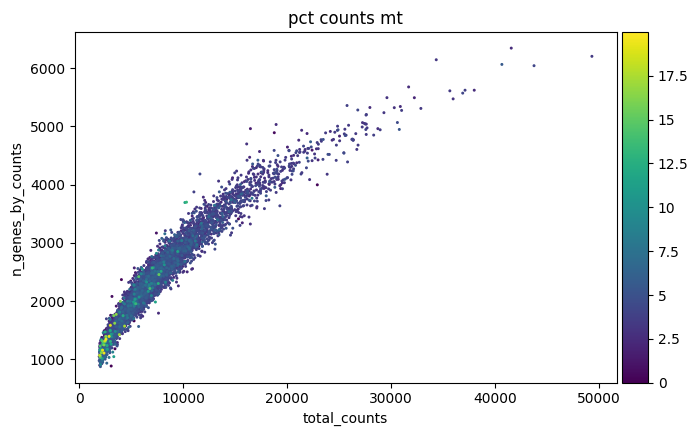

In [8]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
adata = adata[adata.obs['pct_counts_mt'] < 10].copy()

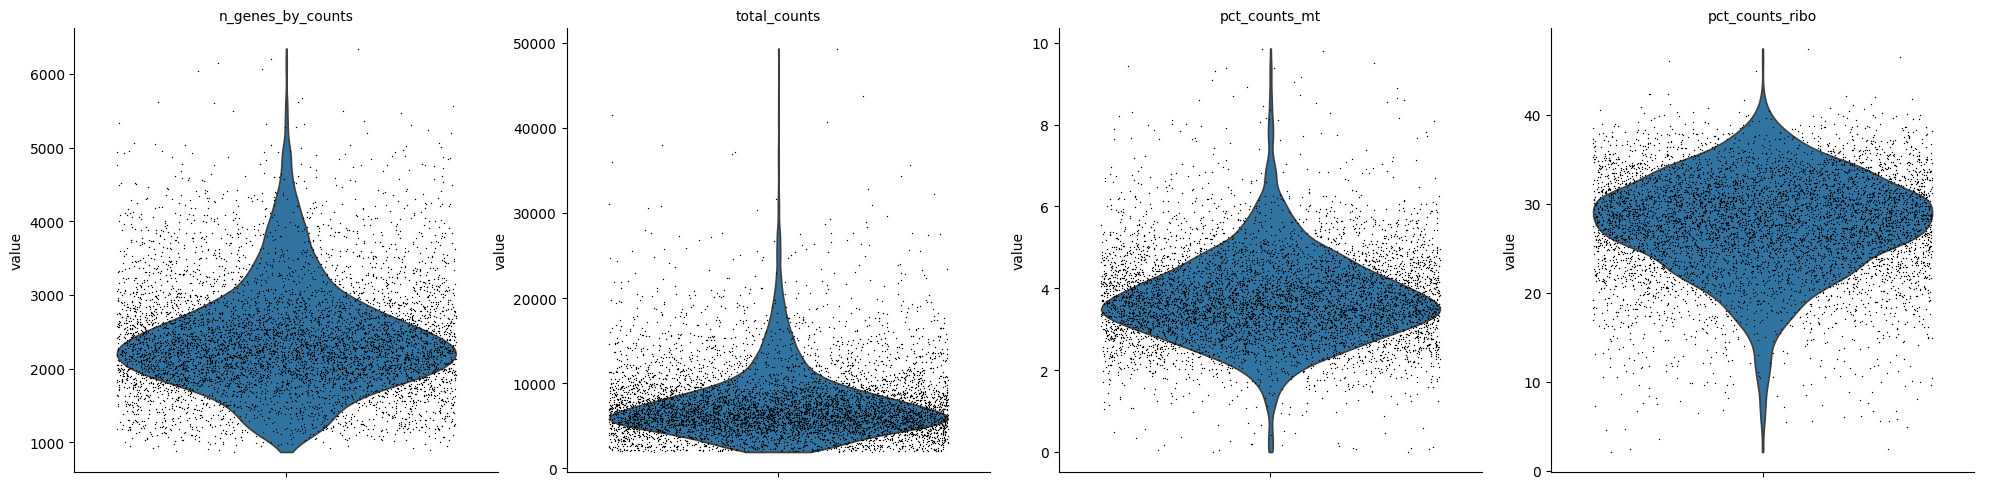

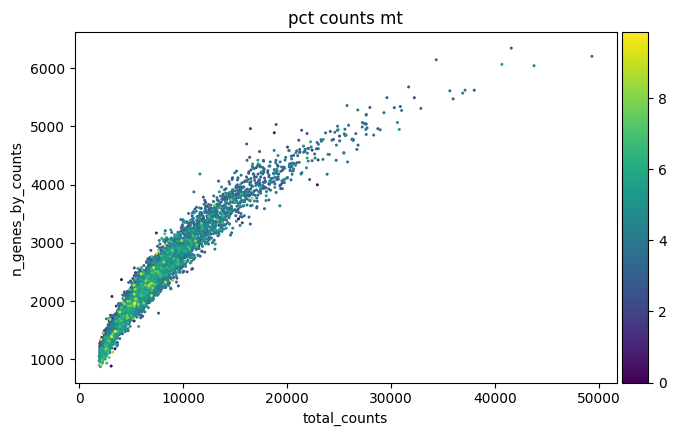

In [10]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [11]:
adata.obs['scrublet_predicted_doublets'].value_counts()

scrublet_predicted_doublets
False    6513
Name: count, dtype: int64

In [12]:
print(adata)

AnnData object with n_obs × n_vars = 6513 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'souporcell_doublet_prediction', 'souporcell_doublet_logprob', 'batch', 'sample', 'time_id', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'new_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


In [13]:
#now filtering genes
#n_cells = adata.n_obs
#threshold = round(n_cells * 0.05)
#sc.pp.filter_genes(adata, min_cells=threshold)
sc.pp.filter_genes(adata, min_cells=3)

In [14]:
print(adata)

AnnData object with n_obs × n_vars = 6513 × 16987
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'souporcell_doublet_prediction', 'souporcell_doublet_logprob', 'batch', 'sample', 'time_id', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'new_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [15]:
#From here we save our obj as a tsv and csv
#exporting extracted data
#exporting count data
# Extract the data from the 'counts' layer of your subsetted object
counts_matrix = adata.X.copy()

# Create the DataFrame
# The logic to handle sparse vs. dense arrays is still good to have
counts_df = pd.DataFrame(
    counts_matrix.toarray() if hasattr(counts_matrix, 'toarray') else counts_matrix,
    index=adata.obs_names,
    columns=adata.var_names
)

In [16]:
# Save the DataFrame to a .tsv file
counts_df.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/g2g_ipsc/ATO_T06/ATO_T06_countdata.tsv", sep='\t')

In [17]:
#exporting metadata
# Save the observation metadata (cell-level annotations) as a CSV file
adata.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/g2g_ipsc/ATO_T06/ATO_T06_metadata.csv")